In [16]:
%load_ext autoreload
%autoreload 2

import pandas as pd
import time
import matplotlib.pyplot as plt
from itertools import product
from loguru import logger

from carbon.estimate import estimate_carbon_footprint
from carbon.llm import estimate_raw

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [6]:
# Structured Outputs with response_format: {type: "json_schema", ...} are supported for the following models:
models = ['gpt-4o-2024-08-06', 'gpt-4o-mini-2024-07-18']

In [21]:
# From Berners-Lee, M. (2022). *The carbon footprint of everything* (2nd ed.). Greystone Books.

data = [
    ("a disposable diaper", "United States", 0.13),
    ("a roll of toilet paper", "United States", 0.73),
    ("a pint of milk", "United States", 0.9),
    ("a paperback book", "United States", 1),
    ("a night in a hotel", "United States", 75),
    ("a week’s food shopping", "United States", 81),    
]

In [22]:
results = []
for model, (item, country, expected) in product(models, data):
    logger.info(f"Estimating carbon footprint for {item} in {country} using {model} model")
    # using the raw estimate
    start_time = time.time()
    result_raw = estimate_raw(item, country, model=model)
    end_time = time.time()
    results.append({
        "model": model,
        "item": item,
        "country": country,
        "predicted": result_raw.carbon_footprint,
        "expected": expected,
        "time": end_time - start_time,
    })

    logger.info(f"Estimating carbon footprint for {item} in {country} using {model}_carbon model")
    # using our carbon footprint estimate
    start_time = time.time()
    result = estimate_carbon_footprint(item, country, model=model)
    end_time = time.time()
    results.append({
        "model": f"{model}_carbon",
        "item": item,
        "country": country,
        "predicted": result.carbon_footprint,
        "expected": expected,
        "time": end_time - start_time,
    })

2024-08-16 23:15:24.720 | INFO     | __main__:<module>:3 - Estimating carbon footprint for a disposable diaper in United States using gpt-4o-2024-08-06 model
2024-08-16 23:15:27.525 | INFO     | __main__:<module>:17 - Estimating carbon footprint for a disposable diaper in United States using gpt-4o-2024-08-06_carbon model
2024-08-16 23:15:32.675 | INFO     | __main__:<module>:3 - Estimating carbon footprint for a roll of toilet paper in United States using gpt-4o-2024-08-06 model
2024-08-16 23:15:35.128 | INFO     | __main__:<module>:17 - Estimating carbon footprint for a roll of toilet paper in United States using gpt-4o-2024-08-06_carbon model
2024-08-16 23:15:41.323 | INFO     | __main__:<module>:3 - Estimating carbon footprint for a pint of milk in United States using gpt-4o-2024-08-06 model
2024-08-16 23:15:44.279 | INFO     | __main__:<module>:17 - Estimating carbon footprint for a pint of milk in United States using gpt-4o-2024-08-06_carbon model
2024-08-16 23:15:50.029 | INFO  

In [23]:
df = pd.DataFrame(results)
df.head()

,model,item,country,predicted,expected,time
0,gpt-4o-2024-08-06,a disposable diaper,United States,0.250000,0.13,2.804711
1,gpt-4o-2024-08-06_carbon,a disposable diaper,United States,0.159003,0.13,5.149036
2,gpt-4o-2024-08-06,a roll of toilet paper,United States,0.500000,0.73,2.452375
3,gpt-4o-2024-08-06_carbon,a roll of toilet paper,United States,1.217187,0.73,6.193720
4,gpt-4o-2024-08-06,a pint of milk,United States,0.570000,0.90,2.955278


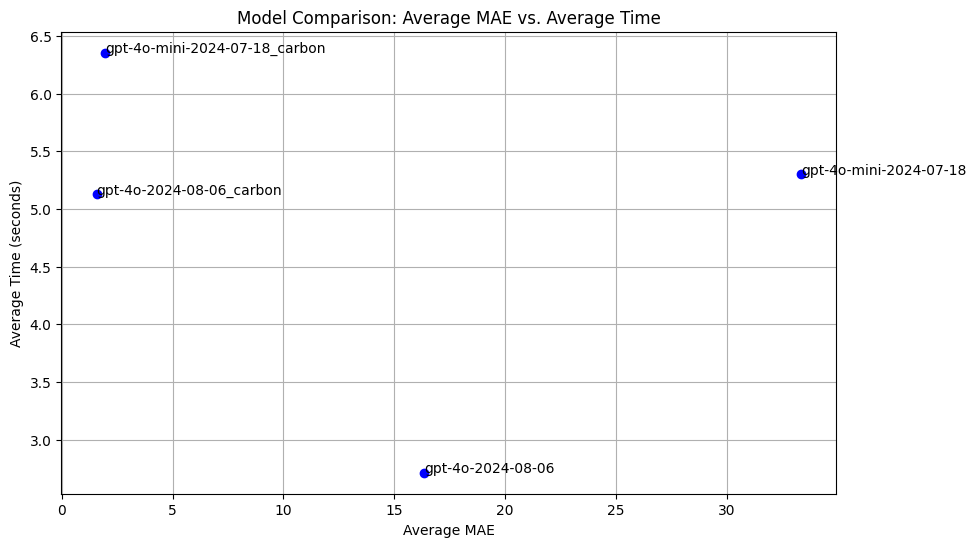

In [24]:
# Calculate MAE for each prediction
df['mae'] = abs(df['predicted'] - df['expected'])

# Group by model to calculate the average MAE and time for each model
model_comparison = df.groupby('model').agg(
    average_mae=('mae', 'mean'),
    average_time=('time', 'mean')
).reset_index()

# Plotting the comparison
plt.figure(figsize=(10, 6))
plt.scatter(model_comparison['average_mae'], model_comparison['average_time'], color='blue')

# Annotate points with model names
for i in range(len(model_comparison)):
    plt.text(model_comparison['average_mae'][i], model_comparison['average_time'][i], model_comparison['model'][i])

plt.xlabel('Average MAE')
plt.ylabel('Average Time (seconds)')
plt.title('Model Comparison: Average MAE vs. Average Time')
plt.grid(True)
plt.show()

In [25]:
df

,model,item,country,predicted,expected,time,mae
0,gpt-4o-2024-08-06,a disposable diaper,United States,0.250000,0.13,2.804711,0.120000
1,gpt-4o-2024-08-06_carbon,a disposable diaper,United States,0.159003,0.13,5.149036,0.029003
2,gpt-4o-2024-08-06,a roll of toilet paper,United States,0.500000,0.73,2.452375,0.230000
3,gpt-4o-2024-08-06_carbon,a roll of toilet paper,United States,1.217187,0.73,6.193720,0.487187
4,gpt-4o-2024-08-06,a pint of milk,United States,0.570000,0.90,2.955278,0.330000
5,gpt-4o-2024-08-06_carbon,a pint of milk,United States,1.536850,0.90,5.749800,0.636850
6,gpt-4o-2024-08-06,a paperback book,United States,1.000000,1.00,3.025483,0.000000
7,gpt-4o-2024-08-06_carbon,a paperback book,United States,4.057290,1.00,4.934824,3.057290
8,gpt-4o-2024-08-06,a night in a hotel,United States,20.000000,75.00,2.217309,55.000000
9,gpt-4o-2024-08-06_carbon,a night in a hotel,United States,70.818803,75.00,6.750599,4.181197
